# **Importing Important Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

### If the GPU is available use it for the computation otherwise use the CPU.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

There are 2 ways to load the Fashion MNIST dataset. 


    1.   Load csv and then inherite Pytorch Dataset class .
    2.   Use Pytorch module torchvision.datasets. It has many popular datasets like MNIST, FashionMNIST, CIFAR10 e.t.c.
    
    

*   We use DataLoader class from torch.utils.data to load data in batches  in both method.
* Comment out the code of a method which you are not using. 






### 1.    Using a Dataset class.
    
   *   First load the data from the disk using pandas read_csv() method.

   *   Now inherit Dataset class in your own class that you are building,    lets say FashionData.

        *  It has 2 methods: __get_item__( ) and __len__().
        * __get_item__( ) return the images and labels and __len__( ) returns the number of items in a dataset.

In [3]:
train_csv = pd.read_csv("../input/fashion-mnist_train.csv")
test_csv = pd.read_csv("../input/fashion-mnist_test.csv")

In [4]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [5]:
# Transform data into Tensor that has a range from 0 to 1
train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

### 2. Using FashionMNIST class from torchvision module.


*   It will download the dataset first time.




In [6]:
"""
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  
"""                                               

'\ntrain_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=\n                                                transforms.Compose([transforms.ToTensor()]))\ntest_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=\n                                               transforms.Compose([transforms.ToTensor()]))  \n'

In [7]:
"""
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)
"""                                          

'\ntrain_loader = torch.utils.data.DataLoader(train_set, \n                                           batch_size=100)\ntest_loader = torch.utils.data.DataLoader(test_set,\n                                          batch_size=100)\n'

### We have 10 types of clothes in FashionMNIST dataset.


> Making a method that return the name of class for the label number.
ex. if the label is 5, we return Sandal.



In [8]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

### Playing with data and displaying some images using matplotlib imshow() method.





In [9]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [10]:
len(train_set)

60000

2


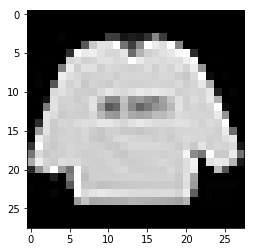

In [11]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [12]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  Pullover, Ankle Boot, Shirt, T-shirt/Top, Dress, Coat, Coat, Sandal, Coat, Bag, 

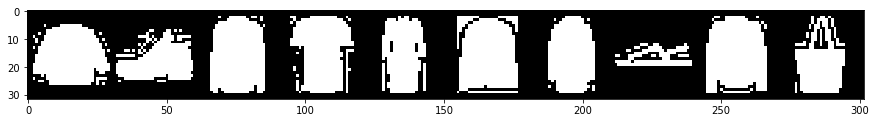

In [13]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")


## Building a CNN 


*   Make a model class (FashionCNN in our case)
    * It inherit nn.Module class that is a super class for all the neural networks in Pytorch.
* Our Neural Net has following layers:
    * Two Sequential layers each consists of following layers-
        * Convolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in 1st layer and padding = 0 in second one. Stride of 1 in both layer.
        * Batch Normalization layer.
        * Acitvation function: ReLU.
        * Max Pooling layer with kernel size of 2 * 2 and stride 2.
     * Flatten out the output for dense layer(a.k.a. fully connected layer).
     * 3 Fully connected layer  with different in/out features.
     * 1 Dropout layer that has class probability p = 0.25.
  
     * All the functionaltiy is given in forward method that defines the forward pass of CNN.
     * Our input image is changing in a following way:
        * First Convulation layer : input: 28 \* 28 \* 3, output: 28 \* 28 \* 32
        * First Max Pooling layer : input: 28 \* 28 \* 32, output: 14 \* 14 \* 32
        * Second Conv layer : input : 14 \* 14 \* 32, output: 12 \* 12 \* 64
        * Second Max Pooling layer : 12 \* 12 \* 64, output:  6 \* 6 \* 64
    * Final fully connected layer has 10 output features for 10 types of clothes.

> Lets implementing the network...





In [14]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out


### Making a model of our CNN class

*   Creating a object(model in the code)
*   Transfering it into GPU if available.
*  Defining a Loss function. we're using CrossEntropyLoss() here.
*  Using Adam algorithm for optimization purpose.



**RESNET50**

In [15]:
#model = FashionCNN()
from torchvision import transforms, utils, models
model = models.resnet50(pretrained=True)
#model = torch.nn.resnet50(*(list(oldmodel.children())[:-1]))


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:03, 31857957.47it/s]


In [16]:
def change_layers(model):
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(2048, 10, bias=True)
    #model.drop= nn.Dropout2d(p=0.25)
    #model.fc2= nn.Linear(in_features=1000, out_features=120, bias=True)
    #model.fc3= nn.Linear(in_features=120, out_features=10, bias=True)
    return model

In [17]:
change_layers(model)
error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
if(torch.cuda.is_available()):
    model = model.cuda()
    
model.to(device)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

**GOOGLE NET / INCEPTION NET**

In [18]:
import torch.nn.functional as F


def conv_relu(in_channels, out_channels, kernel, stride=1, padding=0):
    layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, stride, padding),
        nn.BatchNorm2d(out_channels, eps=1e-3),
        nn.ReLU(True))
    return layer
 
 
 
 
class Inception(nn.Module):
    def __init__(self,in_channel,c1,c2,c3,c4):
        super(Inception,self).__init__()
        self.norm1_1=nn.BatchNorm2d(in_channel,eps=1e-3)
        self.p1_1=nn.Conv2d(in_channels=in_channel,out_channels=c1,kernel_size=1)
        self.norm2_1 = nn.BatchNorm2d(in_channel, eps=1e-3)
        self.p2_1=nn.Conv2d(in_channels=in_channel,out_channels=c2[0],kernel_size=1)
        self.norm2_2 = nn.BatchNorm2d(c2[0], eps=1e-3)
        self.p2_2=nn.Conv2d(in_channels=c2[0],out_channels=c2[1],kernel_size=3,padding=1)
        self.norm3_1 = nn.BatchNorm2d(in_channel, eps=1e-3)
        self.p3_1=nn.Conv2d(in_channels=in_channel,out_channels=c3[0],kernel_size=1)
        self.norm3_2 = nn.BatchNorm2d(c3[0], eps=1e-3)
        self.p3_2=nn.Conv2d(in_channels=c3[0],out_channels=c3[1],kernel_size=5,padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.norm4_2 = nn.BatchNorm2d(in_channel, eps=1e-3)
        self.p4_2 = nn.Conv2d(in_channels=in_channel, out_channels=c4, kernel_size=1)
 
    def forward(self, x):
        p1=self.p1_1(F.relu(self.norm1_1(x)))
        p2=self.p2_2(F.relu(self.norm2_2(self.p2_1(F.relu(self.norm2_1(x))))))
        p3=self.p3_2(F.relu(self.norm3_2(self.p3_1(F.relu(self.norm3_1(x))))))
        p4=self.p4_2(F.relu(self.norm4_2(self.p4_1(x))))
        return torch.cat((p1,p2,p3,p4),dim=1)
 
#Test Inception block
# test_net = Inception(3, 64, (48, 64), (64, 96), 32)
# test_x = Variable(torch.zeros(1, 3, 96, 96))
# print('input shape: {} x {} x {}'.format(test_x.shape[1], test_x.shape[2], test_x.shape[3]))
# test_y = test_net(test_x)
# print('output shape: {} x {} x {}'.format(test_y.shape[1], test_y.shape[2], test_y.shape[3]))
 
 
 
class GoogleNet(nn.Module):
    def __init__(self,in_channel,num_classes):
        super(GoogleNet,self).__init__()
        layers=[]
        layers+=[nn.Conv2d(in_channels=in_channel,out_channels=64,kernel_size=7,stride=2,padding=3),
                 nn.ReLU(),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1)]
        layers+=[nn.Conv2d(in_channels=64,out_channels=64,kernel_size=1),
                 nn.Conv2d(in_channels=64,out_channels=192,kernel_size=3,padding=1),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1)]
        layers+=[Inception(192,64,(96,128),(16,32),32),
                 Inception(256,128,(128,192),(32,96),64),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1)]
        layers+=[Inception(480, 192, (96, 208), (16, 48), 64),
                 Inception(512, 160, (112, 224), (24, 64), 64),
                 Inception(512, 128, (128, 256), (24, 64), 64),
                 Inception(512, 112, (144, 288), (32, 64), 64),
                 Inception(528, 256, (160, 320), (32, 128), 128),
               nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        layers += [Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AvgPool2d(kernel_size=2)]
        self.net = nn.Sequential(*layers)
        self.dense=nn.Linear(1024,num_classes)
 
 
    def forward(self,x):
        x=self.net(x)
        x=x.view(-1,1024*1*1)
        x=self.dense(x)
        return x


In [19]:

model=GoogleNet(1,10).cuda()
error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
if(torch.cuda.is_available()):
    model = model.cuda()
    
model.to(device)



GoogleNet(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Inception(
      (norm1_1): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (norm2_1): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (norm2_2): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (p2_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm3_1): BatchNorm2d(192, eps=0.001, moment

**ALEX NET**

In [20]:
model=models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.torch/models/alexnet-owt-4df8aa71.pth
244418560it [00:06, 35209505.75it/s]


In [21]:
model.features[0]=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
model.classifier[6]=nn.Linear(in_features=4096, out_features=10, bias=True)
error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
if(torch.cuda.is_available()):
    model = model.cuda()
    
model.to(device)


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0

## Training a network and Testing it on test dataset

In [22]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


Iteration: 500, Loss: 2.2991783618927, Accuracy: 10%
Iteration: 1000, Loss: 2.2957711219787598, Accuracy: 9%
Iteration: 1500, Loss: 2.307579278945923, Accuracy: 10%
Iteration: 2000, Loss: 2.3003411293029785, Accuracy: 10%
Iteration: 2500, Loss: 2.301276683807373, Accuracy: 10%
Iteration: 3000, Loss: 2.306760787963867, Accuracy: 10%


### Visualizing the Loss and Accuracy with Iterations


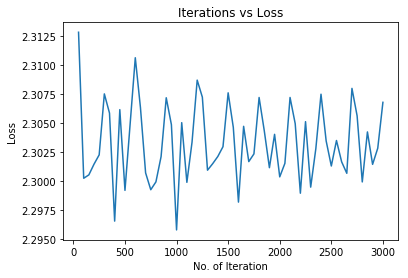

In [23]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

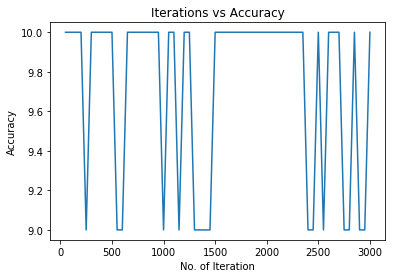

In [24]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

### Looking the Accuracy in each class of FashionMNIST dataset

In [25]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 1.55%
Accuracy of Trouser: 5.08%
Accuracy of Pullover: 18.65%
Accuracy of Dress: 6.08%
Accuracy of Coat: 1.43%
Accuracy of Sandal: 0.00%
Accuracy of Shirt: 0.00%
Accuracy of Sneaker: 8.22%
Accuracy of Bag: 0.85%
Accuracy of Ankle Boot: 57.95%


### Printing the Confusion Matrix 

In [26]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [27]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.10      0.09      0.10    360000
           1       0.10      0.06      0.08    360000
           2       0.10      0.12      0.11    360000
           3       0.10      0.01      0.01    360000
           4       0.10      0.20      0.13    360000
           5       0.10      0.08      0.09    360000
           6       0.10      0.05      0.07    360000
           7       0.10      0.13      0.11    360000
           8       0.10      0.12      0.11    360000
           9       0.10      0.14      0.12    360000

   micro avg       0.10      0.10      0.10   3600000
   macro avg       0.10      0.10      0.09   3600000
weighted avg       0.10      0.10      0.09   3600000




### This is my implementation of deep learning in FashionMNIST dataset using Pytorch. I've achieved 93% test accuracy. Change those layer architecture or parameters to make it better. 
***I hope you like it. Give your feedback. It helps me to a lot. Thank you. :)***